### Import Dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [3]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [7]:
train_df = create_df(r"D:\download\archive(5)\Oily-Dry-Skin-Types\train")
val_df = create_df(r"D:\download\archive(5)\Oily-Dry-Skin-Types\valid")
test_df = create_df(r"D:\download\archive(5)\Oily-Dry-Skin-Types\test")

In [8]:
train_df = pd.concat([train_df, val_df, test_df])

In [9]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [10]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [11]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [12]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [13]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [14]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [14]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [15]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Dinesh/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:38<00:00, 2.67MB/s]  


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [17]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [18]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    scheduler.step()
    
    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

c:\Users\Dinesh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epochs 1 train loss 0.04671219264359192 acc 0.4502181673938913 val loss 0.035476283232371016 acc 0.49523809523809526
Epochs 2 train loss 0.0239797564122186 acc 0.6652122173740579 val loss 0.04295185369158548 acc 0.45714285714285713
Epochs 3 train loss 0.015735579773529518 acc 0.8107893692978977 val loss 0.039695810325562006 acc 0.5746031746031746
Epochs 4 train loss 0.00939432567946734 acc 0.8909163030543436 val loss 0.042716471732608854 acc 0.5428571428571428
Epochs 5 train loss 0.007360714332942025 acc 0.9238397461324871 val loss 0.02657602930825854 acc 0.7206349206349206
Epochs 6 train loss 0.005155814429601002 acc 0.9408964696548988 val loss 0.03758812272359455 acc 0.6698412698412698
Epochs 7 train loss 0.003950660063403791 acc 0.9559698532328441 val loss 0.032415410072084455 acc 0.7238095238095238
Epochs 8 train loss 0.0032015929544600926 acc 0.9682665608885362 val loss 0.034788750466846284 acc 0.6888888888888889
Epochs 9 train loss 0.003074525611660562 acc 0.9674732249107497 val 

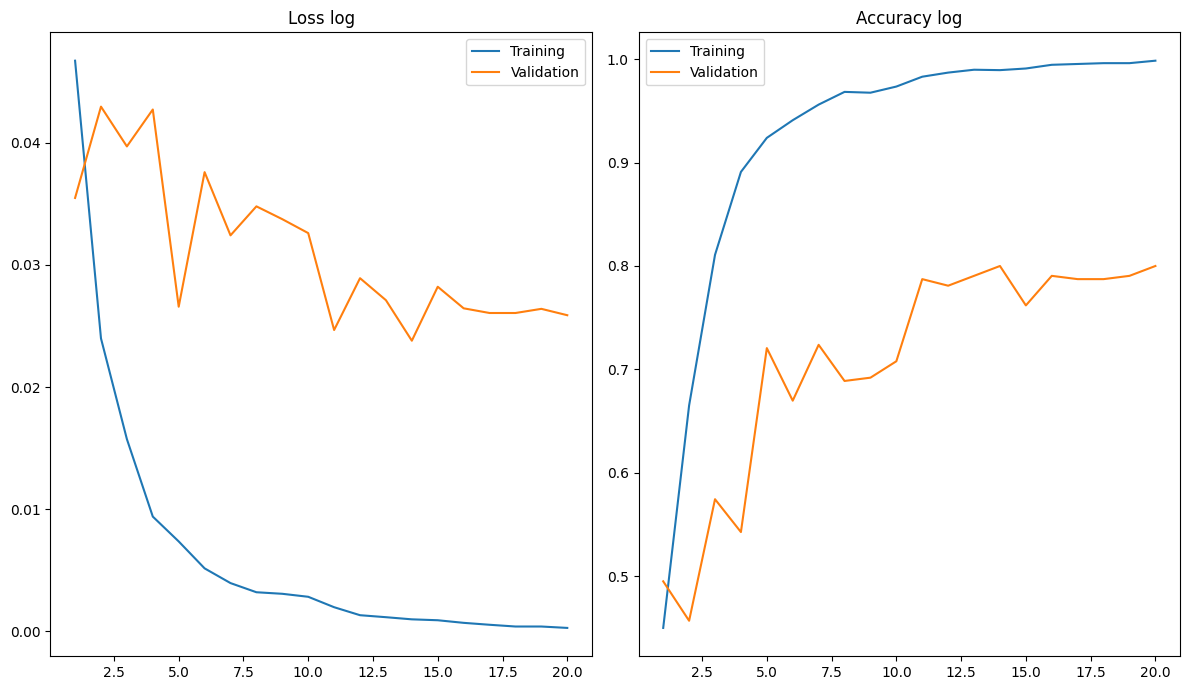

In [19]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [20]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [21]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

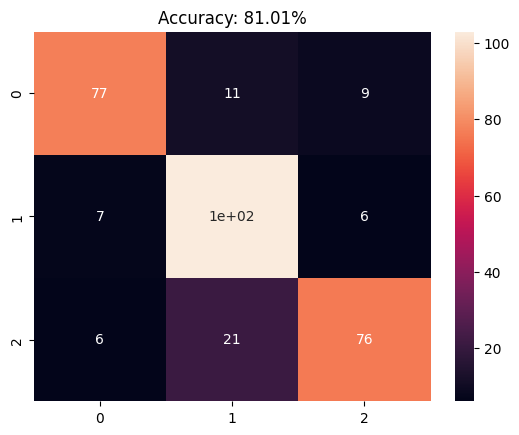

In [22]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [23]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        97
           1       0.76      0.89      0.82       116
           2       0.84      0.74      0.78       103

    accuracy                           0.81       316
   macro avg       0.82      0.81      0.81       316
weighted avg       0.81      0.81      0.81       316



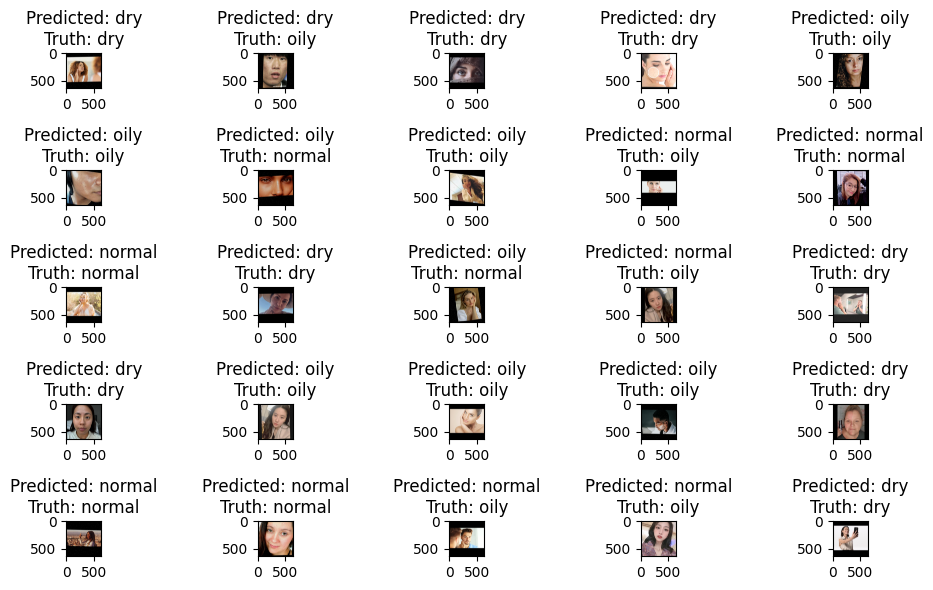

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1
        
plt.tight_layout()
plt.show()

In [5]:
# ... (rest of your training loop)

# Save the best model
torch.save(best_model.state_dict(), r"C:\Users\Dinesh\Desktop\skintype\best_model.pth")

NameError: name 'best_model' is not defined

In [3]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [4]:
img_path = r"D:\download\archive(5)\Oily-Dry-Skin-Types\train\normal\normal_f6e4461d9ab63dd8c1e6_jpg.rf.457d2d4da6917406b5c4cb3db4745bf8.jpg"
predict1(img_path)

NameError: name 'predict1' is not defined

In [47]:
img_path = r"D:\download\archive(5)\Oily-Dry-Skin-Types\train\normal\normal_f6e4461d9ab63dd8c1e6_jpg.rf.16874b40862aab3209b018aee284a7fb.jpg"
predict1(img_path)

c:\Users\Dinesh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


'normal'

In [2]:
img_path = r"D:\download\archive(5)\Oily-Dry-Skin-Types\train\dry\dry_fb69d95f59d28a89f730_jpg.rf.ba0ed1e6a27b744556c1c68c65f47077.jpg"
predict1(img_path)

NameError: name 'predict1' is not defined

In [4]:
img_path = r"D:\download\archive(5)\Oily-Dry-Skin-Types\train\oily\oily_eb867888f59204b92678_jpg.rf.5cbf38ed2f42bc057b8ed3c4e6af4238.jpg"
predict1(img_path)

NameError: name 'Image' is not defined

In [3]:
def predict1(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return index_label[out.argmax(1).item()]

In [11]:
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [13]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

# Define constants
OUT_CLASSES = 3  # Make sure this matches your original setup

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [9]:
# Import necessary libraries
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

# Define constants
OUT_CLASSES = 1000  # Make sure this matches your original setup

# Load the saved model
def load_model(path):
    # Initialize the ResNet50 model architecture
    loaded_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Modify the fully connected layer to match our class count
    num_ftrs = loaded_model.fc.in_features
    loaded_model.fc = nn.Linear(num_ftrs, OUT_CLASSES)

    # Load the saved model weights
    loaded_model.load_state_dict(torch.load(path), strict=False)
    loaded_model = loaded_model.to(device)
    loaded_model.eval()
    print("Model loaded successfully.")
    return loaded_model

# Load the model from the saved file
model_path = "best_model.pth"
loaded_model = load_model(model_path)


C:\Users\Dinesh\AppData\Local\Temp\ipykernel_11200\139653780.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(path), strict=False

NameError: name 'device' is not defined

In [14]:
from torchvision import transforms

# Define the transformation for prediction
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match the input size expected by ResNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [15]:
from PIL import Image
import numpy as np

# Define the prediction function
def predict_new_image(image_path, model, transform):
    # Open the image and apply transformations
    img = Image.open(image_path).convert("RGB")
    img = transform(np.array(img))
    img = img.unsqueeze(0)  # Add batch dimension

    # Move image tensor to device (GPU if available)
    img = img.to(device)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(1).item()

    # Map prediction to label
    return index_label[pred]

# Example usage
image_path = r"D:\download\archive(5)\Oily-Dry-Skin-Types\train\oily\oily_eb867888f59204b92678_jpg.rf.5cbf38ed2f42bc057b8ed3c4e6af4238.jpg"  # Path to the new image
predicted_label = predict_new_image(image_path, loaded_model, transform)
print(f"Predicted Skin Type: {predicted_label}")


Predicted Skin Type: oily


C:\Users\Dinesh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [16]:
# Example usage
image_path = r"D:\download\archive(5)\Oily-Dry-Skin-Types\train\normal\normal_f4679b83afe453307a9d_jpg.rf.e185a90d86abc4f4fae97c6930e865ba.jpg"  # Path to the new image
predicted_label = predict_new_image(image_path, loaded_model, transform)
print(f"Predicted Skin Type: {predicted_label}")


Predicted Skin Type: normal


In [17]:
# Example usage
image_path = r"D:\download\archive(5)\Oily-Dry-Skin-Types\train\dry\dry_dfb8d2eb7fd00732cc8f_jpg.rf.4f63eccb2f43e0e8127385754b4c1722.jpg"  # Path to the new image
predicted_label = predict_new_image(image_path, loaded_model, transform)
print(f"Predicted Skin Type: {predicted_label}")


Predicted Skin Type: dry


In [18]:
# Example usage
image_path = r"C:\Users\Dinesh\Pictures\Camera Roll\WIN_20241106_12_30_15_Pro.jpg"  # Path to the new image
predicted_label = predict_new_image(image_path, loaded_model, transform)
print(f"Predicted Skin Type: {predicted_label}")


Predicted Skin Type: normal


In [21]:
# Example usage
image_path = r"D:\download\istockphoto-1214632569-612x612.jpg"  # Path to the new image
predicted_label = predict_new_image(image_path, loaded_model, transform)
print(f"Predicted Skin Type: {predicted_label}")


Predicted Skin Type: dry


In [32]:
import gradio as gr
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

# Define the transformation for prediction
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match the input size expected by ResNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

index_label = {0: "dry", 1: "normal", 2: "oily"}
model_path = "best_model.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
def load_model(path):
    # Initialize the ResNet50 model architecture
    loaded_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Modify the fully connected layer to match our class count
    num_ftrs = loaded_model.fc.in_features
    loaded_model.fc = nn.Linear(num_ftrs, 1000)

    # Load the saved model weights
    loaded_model.load_state_dict(torch.load(path, map_location=device), strict=False)
    loaded_model = loaded_model.to(device)
    loaded_model.eval()
    print("Model loaded successfully.")
    return loaded_model

loaded_model = load_model(model_path)

# Prediction function
def predict_new_image(image, model, transform):
    # Convert image to RGB and preprocess
    img = Image.fromarray(image).convert("RGB")
    img = transform(np.array(img))
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)  # Move to device (GPU if available)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(1).item()

    # Map prediction to label
    return index_label[pred]

# Recommendation logic
def get_recommendations(skin_type):
    # Filter recommendations from dataset (example shown with placeholders)
    cosmetics_df = pd.read_csv("cosmetics.csv")
    recommended_products = cosmetics_df[cosmetics_df[skin_type] == 1]
    recommendations = recommended_products[['Name', 'Type']].to_dict(orient='records')
    return recommendations

# Define the Gradio function
def gradio_predict(image):
    skin_type = predict_new_image(image, loaded_model, transform)
    #recommendations = get_recommendations(skin_type)
    return {"Skin Type": skin_type}

# Create the Gradio interface
gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="numpy"),
    outputs="json",
    title="Skin Type Prediction",
    description="Upload an image of your skin to predict whether it is Dry, Normal, or Oily, and get product recommendations.",
).launch(debug=True)


C:\Users\Dinesh\AppData\Local\Temp\ipykernel_11200\3609028772.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(path, map_location

Model loaded successfully.
* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
